# NLP: GDPR Compliance Checker​

Koblmiller Julia, Prakash Umakanth, Wadhwani Amar, Willisits Lena​

### Imports

In [34]:
import requests
from bs4 import BeautifulSoup
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### Gathering the baseline data from https://gdpr-info.eu/

In [14]:
base_url = "https://gdpr-info.eu/art-{}-gdpr/"
data = []

for i in range(1, 100):
    try:
        res = requests.get(base_url.format(i), timeout=10)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")
        title = soup.find("span", class_="dsgvo-title")
        if not title:
            continue
        sections = []
        ol = soup.find("ol")
        if ol:
            for j, li in enumerate(ol.find_all("li"), 1):
                sections.append({f"{j}.": li.get_text(" ", strip=True)})
        else:
            div = soup.find("div", class_="entry-content")
            text = div.get_text("\n", strip=True) if div else ""
            sections.append({"1.": text})
        data.append({
            "article_number": i,
            "article_title": title.get_text(strip=True),
            "sections": sections
        })
        time.sleep(0.5)
    except:
        continue

with open("gdpr_articles_baseline.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)


### EDA on baseline data

In [24]:
with open('gdpr_articles_baseline.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

records = []
for article in data:
    article_number = article.get("article_number")
    article_title = article.get("article_title")
    for section in article.get("sections", []):
        for sec_num, sec_text in section.items():
            records.append({
                "article_number": article_number,
                "article_title": article_title,
                "section_number": sec_num,
                "section_text": sec_text
            })

df = pd.DataFrame(records)

In [21]:
print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Shape of dataset: (766, 5)

First 5 rows:
   article_number                  article_title section_number  \
0               1  Subject-matter and objectives             1.   
1               1  Subject-matter and objectives             2.   
2               1  Subject-matter and objectives             3.   
3               2                 Material scope             1.   
4               2                 Material scope             2.   

                                        section_text  text_length  
0  This Regulation lays down rules relating to th...          182  
1  This Regulation protects fundamental rights an...          141  
2  The free movement of personal data within the ...          203  
3  This Regulation applies to the processing of p...          247  
4  This Regulation does not apply to the processi...          579  


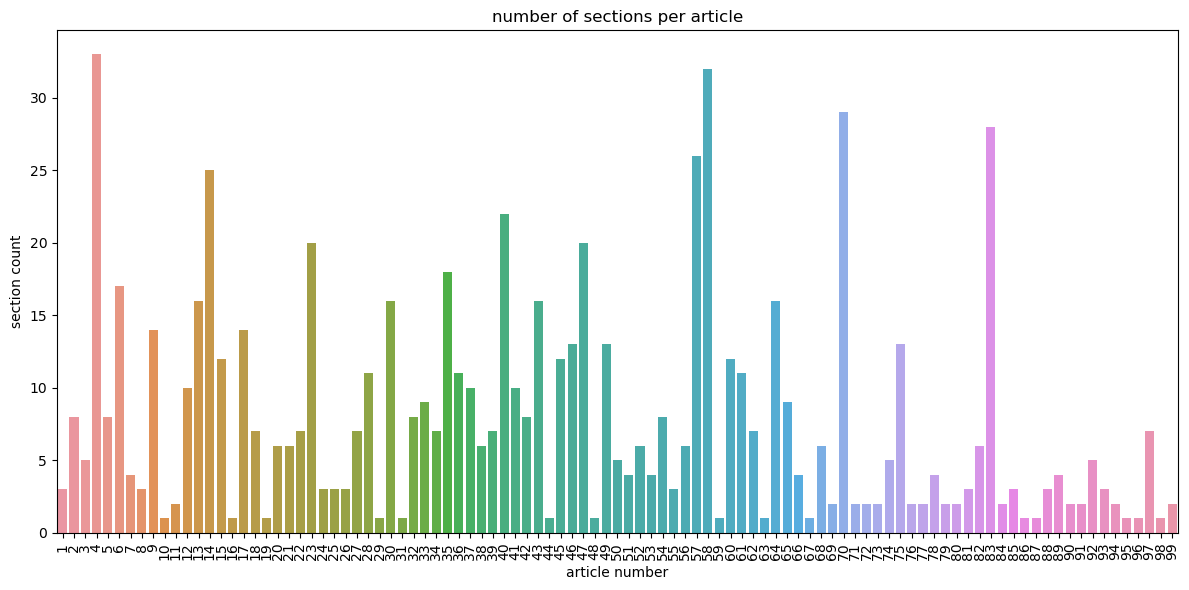

In [27]:
article_counts = df['article_number'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=article_counts.index, y=article_counts.values)
plt.title("number of sections per article")
plt.xlabel("article number")
plt.ylabel("section count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

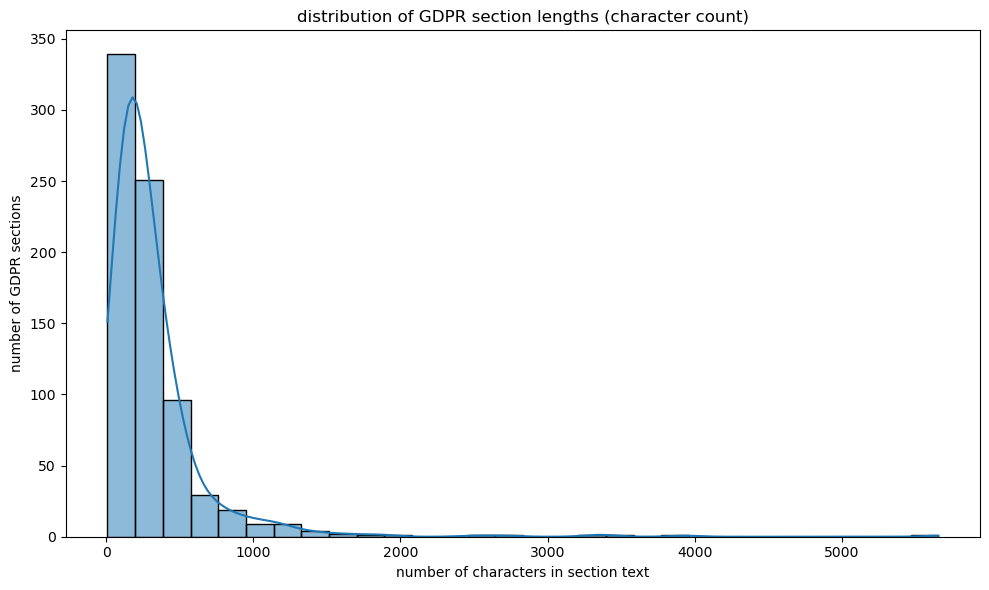

In [28]:
df['text_length'] = df['section_text'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("distribution of GDPR section lengths (character count)")
plt.xlabel("number of characters in section text")
plt.ylabel("number of GDPR sections")
plt.tight_layout()
plt.show()

##### Word count analysis

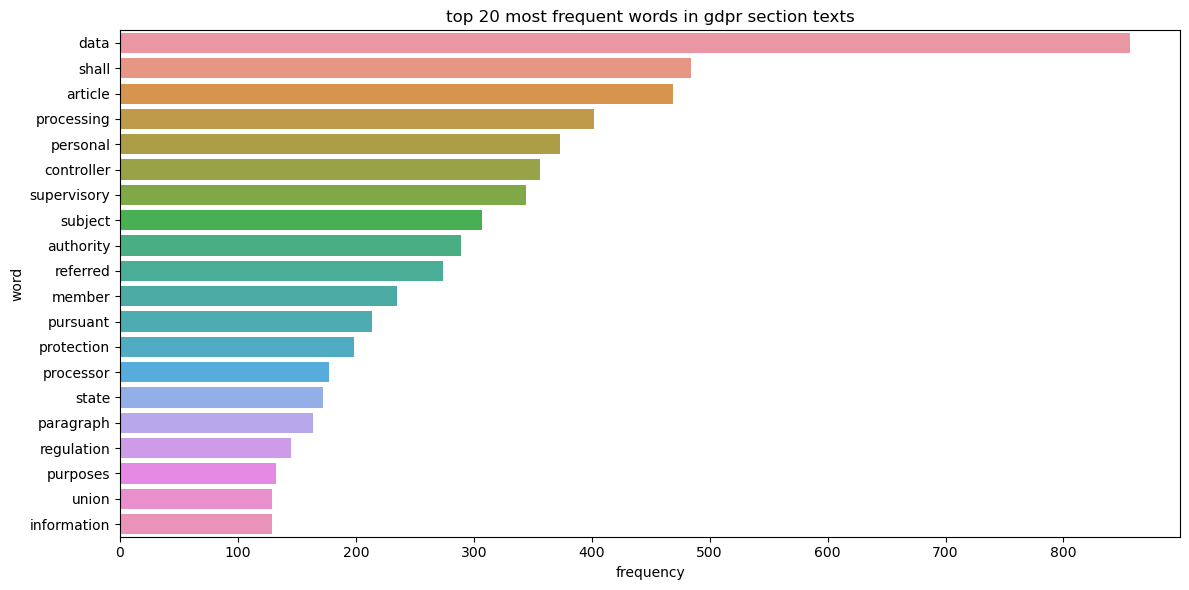

In [29]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['section_text'])
word_freq = X.sum(axis=0)
words = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': words, 'frequency': word_freq.A1})
top_words = freq_df.sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=top_words)
plt.title("top 20 most frequent words in gdpr section texts")
plt.tight_layout()
plt.show()

### Preprocessing the GDPR baseline data

In [37]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # convert all characters to lowercase
    text = text.lower()

    # remove punctuation and digits using regex (keep only letters and spaces)
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize the text into words
    tokens = nltk.word_tokenize(text)

    # remove stopwords and short tokens, and lemmatize remaining words
    tokens = [
        lemmatizer.lemmatize(t)         # reduce word to its base form
        for t in tokens
        if t not in stop_words and len(t) > 2  # filter out stopwords and short words
    ]

    # join the cleaned tokens back into a single string
    return " ".join(tokens)

df["clean_text"] = df["section_text"].apply(preprocess_text)

print(df[["section_text", "clean_text"]].head())

                                        section_text  \
0  This Regulation lays down rules relating to th...   
1  This Regulation protects fundamental rights an...   
2  The free movement of personal data within the ...   
3  This Regulation applies to the processing of p...   
4  This Regulation does not apply to the processi...   

                                          clean_text  
0  regulation lay rule relating protection natura...  
1  regulation protects fundamental right freedom ...  
2  free movement personal data within union shall...  
3  regulation applies processing personal data wh...  
4  regulation apply processing personal data cour...  


##### Example of the preprocessed data

In [38]:
example = df[df["article_number"] == 7].iloc[0]

original_text = example["section_text"]
processed_text = preprocess_text(original_text)

print("Original text:\n")
print(original_text)

print("\nProcessed text:\n")
print(processed_text)

Original text:

Where processing is based on consent, the controller shall be able to demonstrate that the data subject has consented to processing of his or her personal data.

Processed text:

processing based consent controller shall able demonstrate data subject consented processing personal data
